Zach Tretter

June 2020

--------

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 03A - Weather Data

* [Import Weather Data](#Import-Weather-Data)
* [Create Date Spine to Address Missing Values](#Date-Spine-to-Address-Missing-Values)
* [Merge Weather Data onto Date Spine](#Merge-Weather-Data-onto-Date-Spine)
* [Fill in Missing Data from Nearest Station](#Fill-in-Missing-Values)
* [Export Weather Data](#Export-Weather-Data)

--------

## Import Weather Data

[Back-to-top](#Back-to-Top)

Weather Data Source [NOAA](https://www.ncdc.noaa.gov/cdo-web/)

    Climate Data Online (CDO) provides free access to NCDC's archive of global historical weather and climate data in addition to station history information. These data include quality controlled daily, monthly, seasonal, and yearly measurements of temperature, precipitation, wind, and degree days as well as radar data and 30-year Climate Normals.

Four Weather Stations adjacent to Glacier National Park
* [West Glacier Station](https://www.ncdc.noaa.gov/cdo-web/datasets/NORMAL_DLY/stations/GHCND:USC00248809/detail)

* [East Glacier Station](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USC00242629/detail)

* [Many Glacier](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USS0013A27S/detail)

* [St Mary](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USR0000MSTM/detail)

[Documentation of Variables](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf)


-----------------

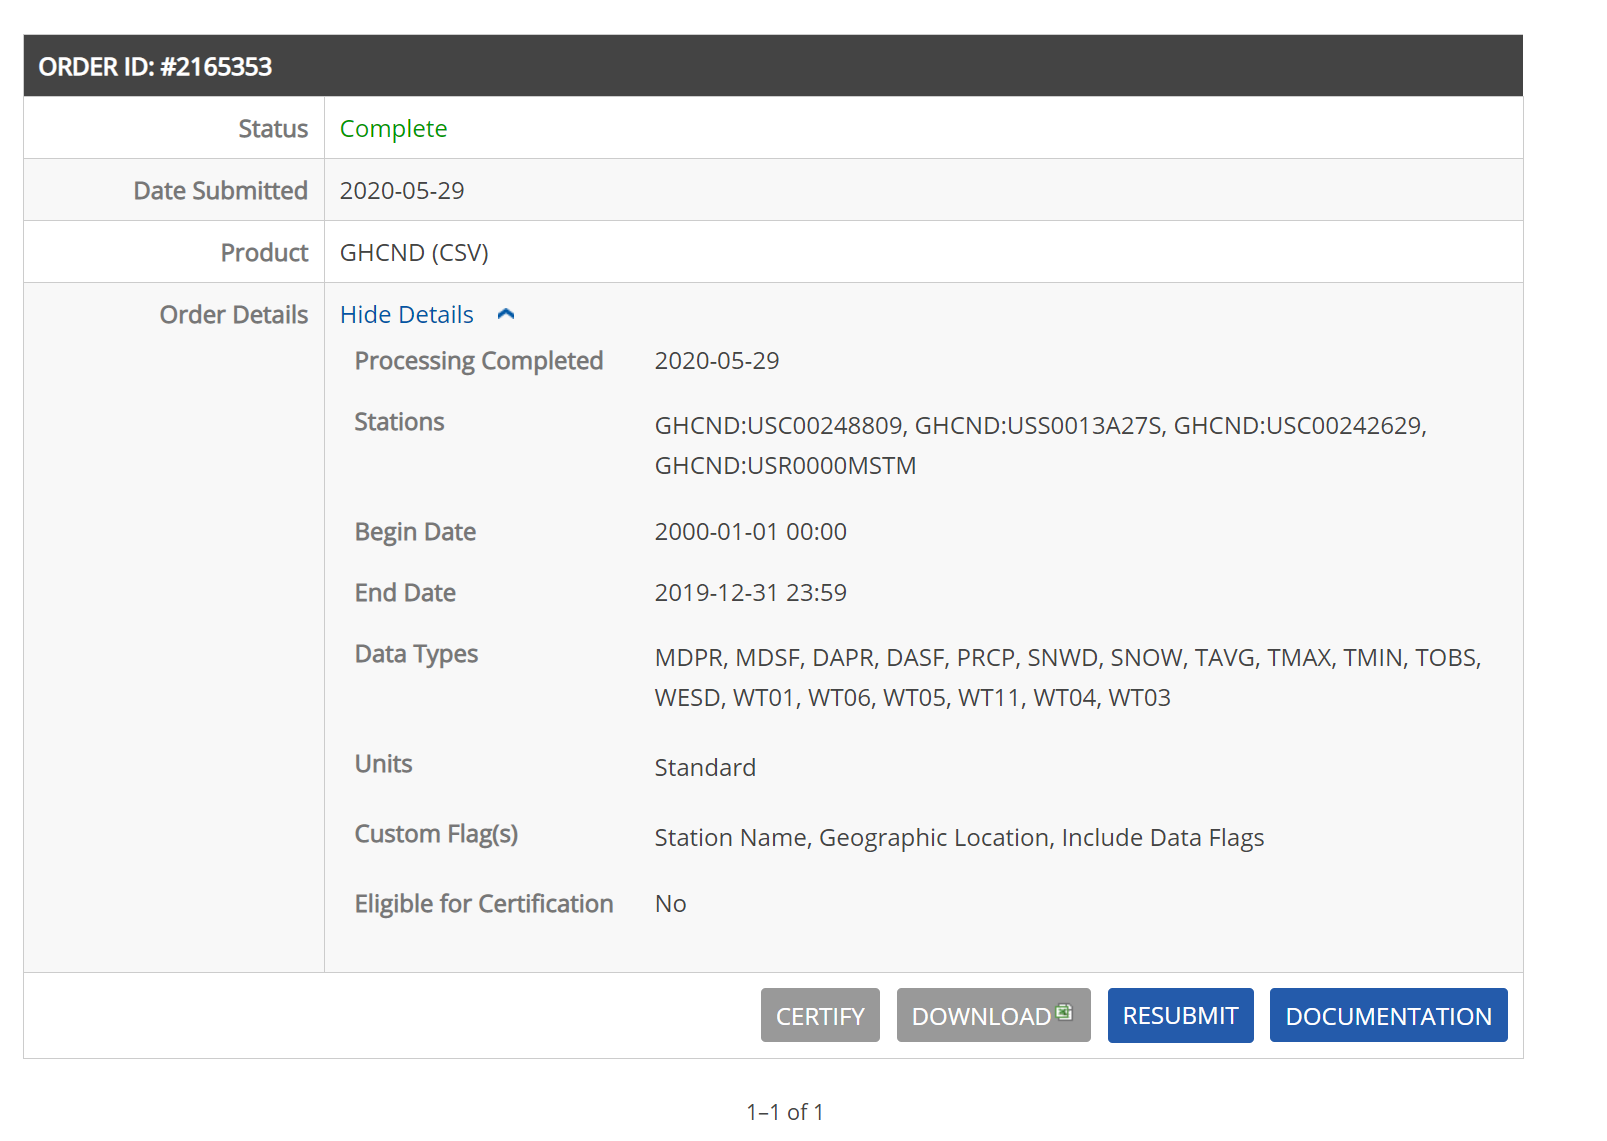

#### Read in Weather CSV

In [2]:
df_weather = pd.read_csv('../data/raw_source_data_CSVs/raw_weather_data_NOAA_CDO.csv')

C:\Users\zacha\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7,9,11,13,17,31,33,35,37,39,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Create a column for date as string and date as datetime

In [3]:
df_weather['date_wx_dt'] = pd.to_datetime(df_weather['DATE'])
df_weather['date_wx_str'] = df_weather['date_wx_dt'].astype(str)

#### Drop the columns not of interest

In [4]:
attributes = [i for i in df_weather.columns if 'ATTR' in i]

weather_type = [i for i in df_weather.columns if "WT" in i]

other = ['DASF',
         'MDSF',
         'DATE',
         'ELEVATION',
#          'LATITUDE',
#          'LONGITUDE',
         'STATION',
         'WESD']

to_drop = attributes + weather_type + other

df_weather = df_weather.drop(columns=to_drop)

#### Create our shorthand names for weather stations

In [5]:
df_weather['wx_station'] = df_weather['NAME'].map({'EAST GLACIER, MT US':'east_glac',
                                                   'WEST GLACIER, MT US':'west_glac',
                                                   'ST. MARY MONTANA, MT US':'st_mary',
                                                   'MANY GLACIER, MT US':'many_glac'})

#### Concatenate date and weather station

In [6]:
df_weather['date_wxstation'] = df_weather['date_wx_str'] + '_' + df_weather['wx_station']

--------

# Date Spine to Address Missing Values

#### Create an empty dataframe of the dates of interest

In [7]:
# Create an emtpy dataframe of the dates of interest
# Read in the data
df_fill = pd.read_csv('../data/02_filltimes_clean.csv')
# Drop the unnamed column that always appears
df_fill = df_fill.drop(columns='Unnamed: 0')

In [8]:
df_date = pd.DataFrame()
df_date['index_date'] = df_fill['date'].unique()
df_date['date'] = df_date['index_date']
df_date.set_index('index_date',inplace=True)

#### Repeat this dataframe for our 4 weather stations

In [9]:
df_date_east_glac = df_date.copy()
df_date_east_glac['station'] = 'east_glac'

df_date_west_glac = df_date.copy()
df_date_west_glac['station'] = 'west_glac'

df_date_many_glac = df_date.copy()
df_date_many_glac['station'] = 'many_glac'

df_date_st_mary = df_date.copy()
df_date_st_mary['station'] = 'st_mary'

#### Append these dataframes together

In [10]:
df_wx_spine = pd.concat([df_date_east_glac,
                         df_date_west_glac,
                         df_date_many_glac,
                         df_date_st_mary
                        ])

In [11]:
df_wx_spine

,date,station
index_date,,
2000-05-01,2000-05-01,east_glac
2000-05-02,2000-05-02,east_glac
2000-05-03,2000-05-03,east_glac
2000-05-04,2000-05-04,east_glac
2000-05-05,2000-05-05,east_glac
...,...,...
2019-09-26,2019-09-26,st_mary
2019-09-27,2019-09-27,st_mary
2019-09-28,2019-09-28,st_mary


In [12]:
df_wx_spine['date_wxstation'] = df_wx_spine['date'] + '_' + df_wx_spine['station']

-------------

## Merge Weather Data onto Date Spine

In [13]:
df_wx = pd.merge(df_wx_spine,
                 df_weather,
                 left_on = 'date_wxstation',
                 right_on = 'date_wxstation',
                 how = 'left')

In [14]:
df_wx = df_wx.sort_values('date_wxstation')
df_wx.reset_index(inplace=True)

In [15]:
df_wx.drop(columns=['index'],inplace=True)

#### Note that we are missing weather data

In [16]:
df_wx.isnull().sum()

date                  0
station               0
date_wxstation        0
NAME                262
LATITUDE            262
LONGITUDE           262
DAPR              12168
MDPR              12161
PRCP               3588
SNOW               6903
SNWD               4298
TAVG               6285
TMAX                373
TMIN                375
TOBS               3391
date_wx_dt          262
date_wx_str         262
wx_station          262
dtype: int64

#### Identify the indices for the missing ALL data for 262 dates

In [17]:
missing_west_glac = df_wx.loc[(df_wx['NAME'].isnull()) &
                             (df_wx['station']=='west_glac')].index

missing_east_glac = df_wx.loc[(df_wx['NAME'].isnull()) &
                             (df_wx['station']=='east_glac')].index

missing_st_mary = df_wx.loc[(df_wx['NAME'].isnull()) &
                             (df_wx['station']=='st_mary')].index


print(f'{len(missing_west_glac)} missing from west glacier')
print(f'{len(missing_west_glac)} missing from east glacier')
print(f'{len(missing_st_mary)} missing from st mary')

30 missing from west glacier
30 missing from east glacier
162 missing from st mary


--------

## Fill in Missing Dates


Use .iloc given the small dataset and few columns

* For missing West Glacier values, use St Mary
    * row directly above 

* For missing East Glacier values, use St Mary
    * row 2 below

* For missing St Mary values, use Many Glacier
    * row directly above 

In [18]:
for i in missing_west_glac:
    df_wx.iloc[i ,4:] = df_wx.iloc[i - 1, 4:]
    
for i in missing_east_glac:
    df_wx.iloc[i ,4:] = df_wx.iloc[i + 2, 4:]

for i in missing_st_mary:
    df_wx.iloc[i ,4:] = df_wx.iloc[i - 1, 4:]

#### Observe that the 2001-08-14 weather data for "St Mary" is now from Many Glacier

In [19]:
df_wx.loc[df_wx['date'] == '2001-08-14']

,date,station,date_wxstation,NAME,LATITUDE,LONGITUDE,DAPR,MDPR,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS,date_wx_dt,date_wx_str,wx_station
1032,2001-08-14,east_glac,2001-08-14_east_glac,"EAST GLACIER, MT US",48.4472,-113.2236,NaN,NaN,0.03,0.0,0.0,NaN,78.0,47.0,65.0,2001-08-14,2001-08-14,east_glac
1033,2001-08-14,many_glac,2001-08-14_many_glac,"MANY GLACIER, MT US",48.8000,-113.6700,NaN,NaN,0.00,NaN,NaN,62.0,83.0,48.0,52.0,2001-08-14,2001-08-14,many_glac
1034,2001-08-14,st_mary,2001-08-14_st_mary,NaN,48.8000,-113.6700,NaN,NaN,0.00,NaN,NaN,62.0,83.0,48.0,52.0,2001-08-14,2001-08-14,many_glac
1035,2001-08-14,west_glac,2001-08-14_west_glac,"WEST GLACIER, MT US",48.5002,-113.9847,NaN,NaN,0.01,0.0,0.0,NaN,87.0,53.0,79.0,2001-08-14,2001-08-14,west_glac


### Review with Crosstab

In [20]:
pd.crosstab(df_wx['station'],
           df_wx['wx_station'])

wx_station,east_glac,many_glac,st_mary,west_glac
station,,,,
east_glac,2990,0,70,0
many_glac,0,3060,0,0
st_mary,0,162,2898,0
west_glac,0,0,30,3030


## Clean up Weather Data

In [21]:
df_wx.isnull().sum()

date                  0
station               0
date_wxstation        0
NAME                262
LATITUDE              0
LONGITUDE             0
DAPR              12168
MDPR              12161
PRCP               3426
SNOW               6903
SNWD               4145
TAVG               6023
TMAX                111
TMIN                113
TOBS               3229
date_wx_dt            0
date_wx_str           0
wx_station            0
dtype: int64

#### Drop rows with lots of nulls that can't easily be assumed to be zero

* 'DAPR'
* 'MDPR'
* 'SNWD'

In [22]:
df_wx.drop(columns = [
    'DAPR',
    'MDPR',
    'SNWD'
                     ],
           inplace=True)

#### Drop rows with lots of nulls that are redundant with other values

* 'TAVG'
* 'TOBS'



In [23]:
df_wx.drop(columns = [
    'TAVG',
    'TOBS',
                     ],
           inplace=True)


#### Drop rows not of any interest

* 'date_wx_dt'
* 'date_wx_str'

In [24]:
df_wx.drop(columns = [
    'date_wx_dt',
    'date_wx_str',
                     ],
           inplace=True)

In [25]:
df_wx.isnull().sum()

date                 0
station              0
date_wxstation       0
NAME               262
LATITUDE             0
LONGITUDE            0
PRCP              3426
SNOW              6903
TMAX               111
TMIN               113
wx_station           0
dtype: int64

***

## Fill in Missing Temperature Values

Fill in Missing Temperature Values using .iloc

In [26]:
df_wx[df_wx['TMAX'].isnull()]['wx_station'].value_counts()

east_glac    107
many_glac      3
west_glac      1
Name: wx_station, dtype: int64

In [27]:
df_wx[df_wx['TMIN'].isnull()]['wx_station'].value_counts()

east_glac    108
many_glac      4
west_glac      1
Name: wx_station, dtype: int64

#### Identify the Column Number to overwrite with iloc

In [28]:
column_num_TMAX = list(df_wx.columns).index('TMAX')
column_num_TMIN = list(df_wx.columns).index('TMIN')

#### West Glacier use St Mary

In [29]:
missing_west_glac_TMAX = df_wx.loc[(df_wx['TMAX'].isnull()) & (df_wx['station']=='west_glac')].index

missing_west_glac_TMIN = df_wx.loc[(df_wx['TMIN'].isnull()) & (df_wx['station']=='west_glac')].index

for index in missing_west_glac_TMAX:
    df_wx.iloc[index, column_num_TMAX] = df_wx.iloc[index - 1, column_num_TMAX]
    
for index in missing_west_glac_TMIN:
    df_wx.iloc[index, column_num_TMIN] = df_wx.iloc[index - 1, column_num_TMIN]  

#### East Glacier use St Mary

In [30]:
missing_east_glac_TMAX = df_wx.loc[(df_wx['TMAX'].isnull()) & (df_wx['station']=='east_glac')].index

missing_east_glac_TMIN = df_wx.loc[(df_wx['TMIN'].isnull()) & (df_wx['station']=='east_glac')].index

for index in missing_east_glac_TMAX:
    df_wx.iloc[index, column_num_TMAX] = df_wx.iloc[index + 2, column_num_TMAX]
    
for index in missing_east_glac_TMIN:
    df_wx.iloc[index, column_num_TMIN] = df_wx.iloc[index + 2, column_num_TMIN]  

#### Many Glacier use St Mary

In [31]:
missing_many_glac_TMAX = df_wx.loc[(df_wx['TMAX'].isnull()) & (df_wx['station']=='many_glac')].index

missing_many_glac_TMIN = df_wx.loc[(df_wx['TMIN'].isnull()) & (df_wx['station']=='many_glac')].index

for index in missing_many_glac_TMAX:
    df_wx.iloc[index, column_num_TMAX] = df_wx.iloc[index + 1, column_num_TMAX]
    
for index in missing_many_glac_TMIN:
    df_wx.iloc[index, column_num_TMIN] = df_wx.iloc[index + 1, column_num_TMIN]  

#### Confirm no nulls remain

In [32]:
df_wx[df_wx['TMAX'].isnull()]['wx_station'].value_counts()

Series([], Name: wx_station, dtype: int64)

In [33]:
df_wx[df_wx['TMIN'].isnull()]['wx_station'].value_counts()

Series([], Name: wx_station, dtype: int64)

*** 
## Deal with Null Values for PRCP

In [34]:
df_wx[df_wx['PRCP'].isnull()]['station'].value_counts()

st_mary      2898
east_glac     498
west_glac      30
Name: station, dtype: int64

#### Identify the Column Number to overwrite with iloc

In [35]:
column_num_PRCP = list(df_wx.columns).index('PRCP')
column_num_PRCP

6

#### Update St Mary to be Many Glacier

In [36]:
missing_st_mary_PRCP = df_wx.loc[(df_wx['PRCP'].isnull()) & (df_wx['wx_station']=='st_mary')].index

for index in missing_st_mary_PRCP:
    df_wx.iloc[index, column_num_PRCP] = df_wx.iloc[index -1, column_num_PRCP]

#### Update East Glacier to be Many Glacier

In [37]:
missing_east_glac_PRCP = df_wx.loc[(df_wx['PRCP'].isnull()) & (df_wx['wx_station']=='east_glac')].index

for index in missing_east_glac_PRCP:
    df_wx.iloc[index, column_num_PRCP] = df_wx.iloc[index + 1, column_num_PRCP]

#### Update West Glacier to be Many Glacier

In [38]:
missing_east_glac_PRCP = df_wx.loc[(df_wx['PRCP'].isnull()) & (df_wx['wx_station']=='east_glac')].index

for index in missing_east_glac_PRCP:
    df_wx.iloc[index, column_num_PRCP] = df_wx.iloc[index - 2, column_num_PRCP]

#### Confirm no nulls remain

In [39]:
df_wx[df_wx['PRCP'].isnull()]['station'].value_counts()

Series([], Name: station, dtype: int64)

## Deal with Null Values for SNOW

#### It seems Many Glacier and St Mary don't collect snow data

In [40]:
df_wx[df_wx['SNOW'].isnull()]['station'].value_counts()

many_glac    3060
st_mary      3060
east_glac     394
west_glac     389
Name: station, dtype: int64

#### Fill the missing values for West Glacier and East Glacier as 0s

In [41]:
df_wx.loc[ (
    ( df_wx['station']=='west_glac') | ( df_wx['station']=='east_glac' )
    ) & df_wx['SNOW'].isnull(),
    'SNOW'] = 0

#### Set the snow value for Many Glacier and St Mary to be East Glacier

In [42]:
column_num_SNOW = list(df_wx.columns).index('SNOW')

In [43]:
missing_st_mary_SNOW = df_wx.loc[(df_wx['SNOW'].isnull()) & (df_wx['station']=='st_mary')].index

for index in missing_st_mary_SNOW:
    df_wx.iloc[index, column_num_SNOW] = df_wx.iloc[index -2, column_num_SNOW]

In [44]:
missing_many_glac_SNOW = df_wx.loc[(df_wx['station']=='many_glac')].index

for index in missing_many_glac_SNOW:
    df_wx.iloc[index, column_num_SNOW] = df_wx.iloc[index -1, column_num_SNOW]

#### Verify no nulls remain

In [45]:
df_wx[df_wx['SNOW'].isnull()]['wx_station'].value_counts()

Series([], Name: wx_station, dtype: int64)

## Create Boolean for Presence of Rain, Snow

In [46]:
df_wx['did_PRCP'] = (df_wx['PRCP']>0).astype(int)
df_wx['did_SNOW'] = (df_wx['SNOW']>0).astype(int)

In [47]:
df_wx.isnull().sum()

date                0
station             0
date_wxstation      0
NAME              262
LATITUDE            0
LONGITUDE           0
PRCP                0
SNOW                0
TMAX                0
TMIN                0
wx_station          0
did_PRCP            0
did_SNOW            0
dtype: int64

### Manually Correct -100 degree day in St Mary

In [48]:
df_wx.loc[df_weather['TMIN']==-100,'TMIN'] = 40

### Drop remaining irrelevant columns

In [49]:
df_wx.drop(columns = [
    'NAME',
    'station'
],inplace=True)

In [51]:
df_wx

,date,date_wxstation,LATITUDE,LONGITUDE,PRCP,SNOW,TMAX,TMIN,wx_station,did_PRCP,did_SNOW
0,2000-05-01,2000-05-01_east_glac,48.4472,-113.2236,0.00,0.0,70.0,39.0,east_glac,0,0
1,2000-05-01,2000-05-01_many_glac,48.8000,-113.6700,0.00,0.0,63.0,37.0,many_glac,0,0
2,2000-05-01,2000-05-01_st_mary,48.7375,-113.4305,0.00,0.0,70.0,39.0,st_mary,0,0
3,2000-05-01,2000-05-01_west_glac,48.5002,-113.9847,0.00,0.0,72.0,31.0,west_glac,0,0
4,2000-05-02,2000-05-02_east_glac,48.4472,-113.2236,0.00,0.0,53.0,39.0,east_glac,0,0
...,...,...,...,...,...,...,...,...,...,...,...
12235,2019-09-29,2019-09-29_west_glac,48.5002,-113.9847,0.02,0.0,41.0,32.0,west_glac,1,0
12236,2019-09-30,2019-09-30_east_glac,48.4472,-113.2236,0.94,7.0,24.0,20.0,east_glac,1,1
12237,2019-09-30,2019-09-30_many_glac,48.8000,-113.6700,0.10,7.0,40.0,18.0,many_glac,1,1
12238,2019-09-30,2019-09-30_st_mary,48.7375,-113.4305,0.10,7.0,33.0,12.0,st_mary,1,1


## Export Weather Data

In [50]:
df_wx.to_csv('../data/03a_weather_clean.csv')